In [1]:
import os 
from itertools import chain
import time


import anndata as ad
import itertools
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import scglue
import networkx as nx
import scipy

os.chdir('/lustre/scratch/kiviaho/spatac/')

date = 20220926
sp_data_folder ='synthetic-spatial/'

In [ ]:
# Highly variable genes have been determined in GLUE preprocessing (PCA,LSI)
# HVG labels have been transferred from RNA data to ATAC data by overlap with the gene region.
# The decoder only decodes these genes onto the new domain

# Download one spatial experiment
experiment = 'exper0'

scglue_model = scglue.models.load_model('glue-results/glue-model-shareseq-synthetic-'+experiment+'.dill')
scglue_model.compile()
graph = nx.read_graphml('glue-results/synthetic-spatial-shareseq-guidance-hvf-'+experiment+'.graphml.gz')

shareseq_atac = ad.read_h5ad('data/preprocessed_shareseq_atac_data.h5ad')
synthetic_spatial_atac_data = ad.read_h5ad('synthetic-spatial/synth_spatial_atac_data_from_cell_counts_20220915_sparse.h5ad')
synthetic_spatial_rna_data = ad.read_h5ad('glue-results/rna-synthetic-spatial-shareseq-'+experiment+'-with-glue-embeddings.h5ad')

if synthetic_spatial_atac_data.var.equals(shareseq_atac.var.drop(columns=['highly_variable','chromStart'])):
    synthetic_spatial_atac_data.var['highly_variable'] = shareseq_atac.var['highly_variable']
    
spatial_atac_ground_truth = synthetic_spatial_atac_data[synthetic_spatial_atac_data.obs.index.str.contains(experiment)]
spatial_atac_ground_truth = spatial_atac_ground_truth[:,spatial_atac_ground_truth.var['highly_variable']==True]
sp_atac_gt_np = spatial_atac_ground_truth.X.toarray()
avg_cells_per_location = np.mean(spatial_atac_ground_truth.obs.sum(axis=1))

    

In [2]:
# Download all spatial experiments

scglue_model = scglue.models.load_model('glue-results/glue-model-shareseq-synthetic-all_experiments.dill')
scglue_model.compile()
graph = nx.read_graphml('glue-results/synthetic-spatial-shareseq-guidance-hvf-all_experiments.graphml.gz')

shareseq_atac = ad.read_h5ad('data/preprocessed_shareseq_atac_data.h5ad')
synthetic_spatial_atac_data = ad.read_h5ad('synthetic-spatial/synth_spatial_atac_data_from_cell_counts_20220915_sparse.h5ad')
synthetic_spatial_rna_data = ad.read_h5ad('glue-results/rna-synthetic-spatial-shareseq-all_experiments-with-glue-embeddings.h5ad')


if synthetic_spatial_atac_data.var.equals(shareseq_atac.var.drop(columns=['highly_variable','chromStart'])):
    synthetic_spatial_atac_data.var['highly_variable'] = shareseq_atac.var['highly_variable']
    
spatial_atac_ground_truth = synthetic_spatial_atac_data[:,synthetic_spatial_atac_data.var['highly_variable']==True]
sp_atac_gt_np = spatial_atac_ground_truth.X.toarray()

    

[INFO] autodevice: Using CPU as computation device.


In [3]:
# We use a pretrained model to decode Spatial RNA expression into Spatial ATAC data
decoded_atac = scglue_model.decode_data(source_key='rna',target_key='atac',adata=synthetic_spatial_rna_data,graph=graph)


In [4]:
coef = np.sqrt(sp_atac_gt_np.var()/decoded_atac.var())

# coef = sp_atac_gt_np.mean()/decoded_atac.mean() # This is not sufficient scaling
#coef = sp_atac_gt_np.mean()/decoded_atac.mean() * avg_cells_per_location # This scales it too far

In [5]:
test = decoded_atac*coef
test = test.astype(int)

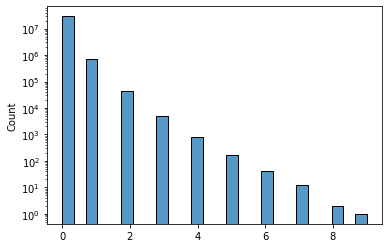

In [6]:
sns.histplot(sp_atac_gt_np[np.random.choice(sp_atac_gt_np.shape[0],1000),:].flatten().astype(int))
plt.yscale('log')

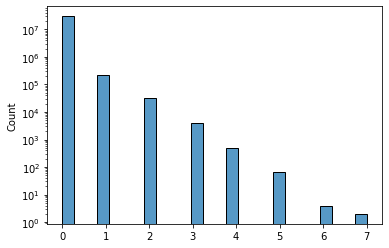

In [7]:
sns.histplot(test[np.random.choice(test.shape[0],1000),:].flatten().astype(int))
plt.yscale('log')

In [123]:
# Everything correlates with everything
scipy.stats.pearsonr(sp_atac_gt_np[20],test[3])

(0.1732406069271629, 6.289605212140217e-200)

In [156]:
i = 2352
len(test[i][test[i] == 0])/len(test[i])

0.9903578961465064

In [154]:
len(sp_atac_gt_np[i][sp_atac_gt_np[i] == 0])/len(sp_atac_gt_np[i])

0.9791422545113663

In [ ]:
synthetic_spatial_atac_data.X

In [ ]:
peak_sums = np.asarray(np.sum(synthetic_spatial_atac_data.X,axis=1)).flatten()
sns.histplot(x=peak_sums,binwidth=500)
plt.axvline(x=np.mean(peak_sums),color='r',linestyle='--')

In [ ]:
synthetic_cell_counts = pd.read_csv('synthetic-spatial/cell_count_df_20220914.csv',index_col=0)
synthetic_cell_counts = synthetic_cell_counts.astype(np.int16)


In [ ]:
atac = ad.read_h5ad('data/share-seq/mouse-brain/share-seq-mouse-brain-atac-data.h5ad')

In [ ]:
n_elements = np.multiply(atac.X.shape[0],atac.X.shape[1])
n_non_zero_entries = len(atac.X.data)
n_zeros = n_elements-n_non_zero_entries
print('{:.3%} non-zero entries'.format(n_non_zero_entries/n_elements))

In [ ]:
sns.histplot(np.array(atac.X.data),binwidth=1)
plt.yscale('log')

In [ ]:
start = time.time()

spots_by_peaks = np.empty((len(synthetic_cell_counts),len(atac.var)),dtype=np.int16)
celltypes = synthetic_cell_counts.columns
for row_idx, row in synthetic_cell_counts.reset_index(drop=True).iterrows():
    select_indices = np.empty((0))

    for col_idx,cell_count in enumerate(row): # Iterates over columns in each row
        celltype = celltypes[col_idx]
        celltype_indices = np.where(atac.obs.celltype==celltype)[0] # Finds ATAC data with cell types

        # Random select from matching indices according to number of cells present
        select_indices = np.append(select_indices,np.random.choice(celltype_indices,cell_count)) 

    # Subsets ATAC by selected index and produces a sum of those cells' peaks, appends to 
    # correct synthetic spot
    spots_by_peaks[row_idx,:] = np.sum(atac.X[select_indices,:].toarray(),axis=0,dtype=np.int16)

elapsed = time.time()-start

In [ ]:
synthetic_spatial_atac_data = ad.AnnData(X=sparse.csr_matrix(spots_by_peaks),
                                  obs=synthetic_cell_counts,
                                  var=atac.var)

In [ ]:
synthetic_spatial_atac_data.write(f'{sp_data_folder}synth_spatial_atac_data_from_cell_counts_{date}_sparse.h5ad')

In [ ]:
# DO THIS
# For experiment_location (spot):
    # For each cell type:
        # Sample a number of peak profiles matching the nunmber of cells present
        # Add sampled peak profiles to the aggregate peak profile
# Results in a spot by peak matrix, where the number of peaks are "unbiased" --> Add noise / sampling error?

In [ ]:
subset_size = [10,20,40,80,160,320,640,1280,2560]
elapsed_time = []

In [ ]:
for size in subset_size:
    synthetic_cell_counts = pd.read_csv('synthetic-spatial/cell_count_df_20220914.csv',index_col=0)
    synthetic_cell_counts = synthetic_cell_counts.astype(np.int16)

    synthetic_cell_counts = synthetic_cell_counts.sample(size)

    start = time.time()
    
    spots_by_peaks = np.empty((len(synthetic_cell_counts),len(atac.var)),dtype=np.int16)
    celltypes = synthetic_cell_counts.columns
    for row_idx, row in synthetic_cell_counts.reset_index(drop=True).iterrows():
        select_indices = np.empty((0))
        
        for col_idx,cell_count in enumerate(row): # Iterates over columns in each row
            celltype = celltypes[col_idx]
            celltype_indices = np.where(atac.obs.celltype==celltype)[0] # Finds ATAC data with cell types
            
            # Random select from matching indices according to number of cells present
            select_indices = np.append(select_indices,np.random.choice(celltype_indices,cell_count)) 

        # Subsets ATAC by selected index and produces a sum of those cells' peaks, appends to 
        # correct synthetic spot
        spots_by_peaks[row_idx,:] = np.sum(atac.X[select_indices,:].toarray(),axis=0,dtype=np.int16)
            
    elapsed = time.time()-start
    print(size,elapsed)
    elapsed_time.append(elapsed)

In [ ]:
celltype_atac_data = atac[atac.obs.celltype=='IN01',:]
rand_cells = np.random.randint(0,len(celltype_atac_data)-1,2)
arr = celltype_atac_data.X[rand_cells,:].toarray()

In [ ]:
# This works in O(n), but all data takes 5min!
spots_by_peaks = np.empty((len(synthetic_cell_counts),len(atac.var)),dtype=np.int16)
celltypes = synthetic_cell_counts.columns
for row_idx, row in synthetic_cell_counts.reset_index(drop=True).iterrows():
    select_indices = np.empty((0))

    for col_idx,cell_count in enumerate(row): # Iterates over columns in each row
        celltype = celltypes[col_idx]
        celltype_indices = np.where(atac.obs.celltype==celltype)[0] # Finds ATAC data with cell types

        # Random select from matching indices according to number of cells present
        select_indices = np.append(select_indices,np.random.choice(celltype_indices,cell_count)) 

    # Subsets ATAC by selected index and produces a sum of those cells' peaks, appends to 
    # correct synthetic spot
    spots_by_peaks[row_idx,:] = np.sum(atac.X[select_indices,:].toarray(),axis=0,dtype=np.int16)


In [ ]:
# This works in O(n). All data would take approx 100min
spots_by_peaks = np.empty((len(synthetic_cell_counts),len(atac.var)),dtype=np.int16)
celltypes = synthetic_cell_counts.columns
for row_idx, row in synthetic_cell_counts.reset_index(drop=True).iterrows():
    for col_idx,cell_count in enumerate(row): # Iterates over columns in each row.
        celltype = celltypes[col_idx]
        celltype_atac_data = atac[atac.obs.celltype==celltype,:]
        rand_cells = np.random.randint(0,len(celltype_atac_data)-1,int(cell_count))
        celltype_peak_sum = np.sum(celltype_atac_data.X[rand_cells,:].toarray(),axis=0,dtype=np.int16)
        spots_by_peaks[row_idx,:] += celltype_peak_sum 

OLD RESULTS:
10 2.2522997856140137
20 4.495478391647339
40 8.95855975151062
80 17.915918827056885
160 35.7022819519043
320 71.20343470573425
640 142.50398230552673
1280 285.6274080276489

In [ ]:
synthetic_cell_counts

In [ ]:
synthetic_spatial = ad.read_h5ad('synthetic-spatial/synth_adata_real_mg_20220914.h5ad')

In [ ]:
synthetic_spatial

In [ ]:
synthetic_spatial.obs

In [ ]:
# Load SHARE-seq data
rna = ad.read_h5ad('data/share-seq/mouse-brain/share-seq-mouse-brain-rna-data.h5ad')
atac = ad.read_h5ad('data/share-seq/mouse-brain/share-seq-mouse-brain-atac-data.h5ad')

# Filter out unannotated & no ATAC data containing cells:
rna = rna[rna.obs['Barcode'].isin(atac.obs['rna.bc'])]
merged_obs = pd.merge(rna.obs['Barcode'],atac.obs,how='inner',left_on='Barcode',right_on='rna.bc')
merged_obs.index = pd.Index(merged_obs.index,dtype='str')
if all(rna.obs['Barcode'].reset_index(drop=True) == merged_obs['Barcode'].reset_index(drop=True)):
    rna.obs = merged_obs

rna.var_names = rna.var['Gene']
del atac


In [ ]:
rna.obs.celltype

In [ ]:
adata = sc.read_10x_h5('data/multiome10x/mouse-brain/e18_mouse_brain_fresh_5k_filtered_feature_bc_matrix.h5')
adata

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)

In [ ]:
# Scanpy standard preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.var_names_make_unique()
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.umap(adata)
sc.tl.leiden(adata)


In [ ]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color='leiden', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='clustering of cells')

In [ ]:
adata.obs.leiden.value_counts()

In [ ]:

c2l_marker_genes_dict = {'Excitatory|Claustrum':['Nr4a2','Synpr'],
                         'Excitatory|Amygdala':['Lypd1','Kcng1','C1ql3'],
                         'Excitatory|hippocampus CA1':['Rprml','Wipf3','Neurod6'],
                         'Excitatory|hippocampus CA3':['Nr4a3','Nptx1','Rnf182'],
                         'Excitatory|thalamus':['Synpo2','Ptpn3','Slc17a6'],
                         'Excitatory|hypothalamus':['Prkch','Ramp3'], # Remove 'Shox2'
                         'Excitatory|cortex':['Sox5','Htr2c','Kcnk2','Dkk3','Rorb','Foxp3','Bcl11b','Cux2','Thsd7a','Cux1'],
                         'Inhibitory|habenula':['Nwd2','Lrrc55','Syt9'],
                         'Inhibitory|cortex/hippocampus':['Lamp5','Dlx6os1','Kcnip1','Sst','Vwc2'], # Removed 'Pvalb','Vip' from these
                         'Inhibitory|striatum':['Drd1','Rgs9','Nexn'],
                         'Inhibitory|thalamus':['Esrrg','Nova1','Scg2','Fign','Syt2','Tmem130'],
                         'Microglia':['Ptprc'],
                         'Neuroblasts':['Sox2','Dcx','Pax6'],
                         'Oligodendrocytes':['Mog','Cnksr3','Plp1'],
                         'OPCs':['Bmp4','Pdgfra'],
                         'Astrocytes':['Aldoc','Slc1a3','Hepacam']}

sc.pl.dotplot(adata,c2l_marker_genes_dict,groupby=['leiden'],dendrogram=True,use_raw=True,figsize=(16,10),standard_scale='var')


In [ ]:
# Add existing clusters
rna_10x_clusters = pd.read_csv('/lustre/scratch/kiviaho/spatac/data/multiome10x/mouse-brain/analysis/clustering/gex/graphclust/clusters.csv')
if all(rna_10x_labels['Barcode'] == rna_10x_multiome.obs.index):
    rna_10x_multiome.obs['Cluster'] = np.array(rna_10x_clusters['Cluster'],dtype='str')
rna_10x_multiome.var_names_make_unique()

In [ ]:

c2l_marker_genes_dict = {'Excitatory|Claustrum':['Nr4a2','Synpr'],
                         'Excitatory|Amygdala':['Lypd1','Kcng1','C1ql3'],
                         'Excitatory|hippocampus CA1':['Rprml','Wipf3','Neurod6'],
                         'Excitatory|hippocampus CA3':['Nr4a3','Nptx1','Rnf182'],
                         'Excitatory|thalamus':['Synpo2','Ptpn3','Slc17a6'],
                         'Excitatory|hypothalamus':['Prkch','Ramp3','Shox2'],
                         'Excitatory|cortex':['Sox5','Htr2c','Kcnk2','Dkk3','Rorb','Foxp3','Bcl11b','Cux2','Thsd7a','Cux1'],
                         'Inhibitory|habenula':['Nwd2','Lrrc55','Syt9'],
                         'Inhibitory|cortex/hippocampus':['Pvalb','Vip','Lamp5','Dlx6os1','Kcnip1','Sst','Vwc2'],
                         'Inhibitory|striatum':['Drd1','Rgs9','Nexn'],
                         'Inhibitory|thalamus':['Esrrg','Nova1','Scg2','Fign','Syt2','Tmem130'],
                         'Microglia':['Ptprc'],
                         'Neuroblasts':['Sox2','Dcx','Pax6'],
                         'Oligodendrocytes':['Mog','Cnksr3','Plp1'],
                         'OPCs':['Bmp4','Pdgfra'],
                         'Astrocytes':['Aldoc','Slc1a3','Hepacam']}

sc.pl.dotplot(rna_10x_multiome,c2l_marker_genes_dict,groupby=['Cluster'],dendrogram=True,figsize=(16,10),standard_scale='var')


In [ ]:
### FUNCTIONS ####
def read_atac_10x(path):
    '''
    Reads ATAC data from standard 10X pipeline output into AnnData format
    '''
    atac = ad.read_mtx(path + 'matrix.mtx')
    atac = atac.transpose()
    barcodes = pd.read_csv(path + 'barcodes.tsv',sep='\t',header=None)
    atac.obs = barcodes.rename(columns={0:'barcode'})
    peaks = pd.read_csv(path + 'peaks.bed',sep='\t',header=None)
    atac.var = peaks.rename(columns={0:'chrom',1:'chromStart',2:'chromEnd'})
    return atac

In [ ]:
# ATAC DATA FORMATTING FOR PEAKS 

# DOWNLOAD ATAC gene by cell matrix into anndata structure
atac_path = 'data/atac/cerebrum-study/'

peak_data = ad.read_mtx(atac_path+'aggregate-section-8-peak-matrix.mtx')
peaknames = pd.read_csv(atac_path+'peaks-aggregate-section-8-peak-matrix.csv')['x']
metadata = pd.read_csv(atac_path+'section-8-metadata.csv')

# Extract chrom data from names
chroms = [s.split(':')[0] for s in peaknames]
chroms_start = [s.split(':')[1].split('-')[0] for s in peaknames]
chroms_end = [s.split(':')[1].split('-')[1] for s in peaknames]

peak_data.obs = pd.DataFrame({'Barcode':metadata['barcode']})
peak_data.var = pd.DataFrame({'chrom':chroms, 'chromStart':chroms_start,'chromEnd':chroms_end})


# Read metadata for all the samples 
files = list(("CEMBA180426_8B","CEMBA190711_8J","CEMBA180430_8B",
             "CEMBA190716_8E","CEMBA190711_8E","CEMBA190716_8J"))

all_metadata = pd.read_csv('data/atac/cerebrum-study/CEMBA-metadata.tsv',sep='\t')
metadata_section_8_from_all = all_metadata[all_metadata['Sample'].isin(files)].reset_index(drop=True)

# Download cell metadata and filter out non-included samples. 

# Filter out unannotated barcodes
filtered_peak_data = peak_data[peak_data.obs['Barcode'].isin(metadata_section_8_from_all['Barcode']),:]
filtered_peak_data.obs = filtered_peak_data.obs.reset_index(drop=True)

filtered_peak_data = filtered_peak_data[np.argsort(filtered_peak_data.obs['Barcode']),:]
filtered_peak_data.obs = filtered_peak_data.obs.reset_index(drop=True)

# Sort all metadata and append to adata
filtered_peak_data = filtered_peak_data[np.argsort(filtered_peak_data.obs['Barcode']),:]
metadata_section_8_from_all = metadata_section_8_from_all.sort_values(by=['Barcode']).reset_index(drop=True)

if all(filtered_peak_data.obs['Barcode'] == metadata_section_8_from_all['Barcode']):
    filtered_peak_data.obs = metadata_section_8_from_all
    print('Properly sorted and integrated')
    
# ATAC-seq data in anndata format ready for analyzing

filtered_peak_data.write_h5ad(atac_path+'aggregate-section-8-valid-peak-count-data.h5ad')


In [ ]:
# ATAC DATA FORMATTING FOR GENES

# DOWNLOAD ATAC gene by cell matrix into anndata structure
atac_path = 'data/atac/cerebrum-study/'

gene = ad.read_mtx(atac_path+'aggregate-section-8-gene-matrix.mtx')
genenames = pd.read_csv(atac_path+'genes-aggregate-section-8-gene-matrix.csv')['x']
metadata = pd.read_csv(atac_path+'section-8-metadata.csv')

gene.obs = pd.DataFrame({'Barcode':metadata['barcode']})
gene.var = pd.DataFrame({'Gene':genenames})

# Download cell metadata and filter out non-included samples. 
files = list(("CEMBA180426_8B","CEMBA190711_8J","CEMBA180430_8B",
             "CEMBA190716_8E","CEMBA190711_8E","CEMBA190716_8J"))

all_metadata = pd.read_csv('data/atac/cerebrum-study/CEMBA-metadata.tsv',sep='\t')
metadata_section_8_from_all = all_metadata[all_metadata['Sample'].isin(files)].reset_index(drop=True)

# Filter out unannotated barcodes
filtered_gene = gene[gene.obs['Barcode'].isin(metadata_section_8_from_all['Barcode']),:]
filtered_gene.obs = filtered_gene.obs.reset_index(drop=True)

filtered_gene = filtered_gene[np.argsort(filtered_gene.obs['Barcode']),:]
filtered_gene.obs = filtered_gene.obs.reset_index(drop=True)

# Sort all metadata and append to adata
filtered_gene = filtered_gene[np.argsort(filtered_gene.obs['Barcode']),:]
metadata_section_8_from_all = metadata_section_8_from_all.sort_values(by=['Barcode']).reset_index(drop=True)

if all(filtered_gene.obs['Barcode'] == metadata_section_8_from_all['Barcode']):
    filtered_gene.obs = metadata_section_8_from_all
    print('Properly sorted and integrated')

# ATAC-seq data in anndata format ready for analyzing
filtered_gene

filtered_gene.write_h5ad(atac_path+'aggregate-section-8-valid-cells.h5ad')

In [ ]:
# RNA DATA FORMATTING
rna_data_path = 'data/rna/cell2location/'
samples = ['5705STDY8058280','5705STDY8058281','5705STDY8058282','5705STDY8058283','5705STDY8058284','5705STDY8058285']

adata_list = []
for sample in samples:
    adata = sc.read_10x_h5(rna_data_path + sample+'_filtered_feature_bc_matrix.h5')
    adata.obs['Cell ID'] = [sample +'_'+ idx for idx in adata.obs.index]
    adata.var_names_make_unique()
    adata_list.append(adata)

adata_rna = ad.concat(adata_list)
metadata = pd.read_csv(rna_data_path+'cell_annotation.csv')



In [ ]:
# Merge & Filter 
adata_rna_filtered = adata_rna[adata_rna.obs['Cell ID'].isin(metadata_ordered['Cell ID']),:]
metadata_ordered = pd.merge(adata_rna.obs,metadata,'inner',on='Cell ID',)

In [ ]:

if all(adata_rna_filtered.obs['Cell ID'].reset_index(drop=True) == metadata_ordered['Cell ID']):
    adata_rna_filtered.obs = metadata_ordered
    

In [ ]:
adata_rna_filtered.write(rna_data_path+'aggregate_cell2location_scrna_samples_annotated.h5ad')